In [16]:
!pip install arch

In [17]:
import pandas as pd
import numpy as np
from arch import arch_model

In [18]:
data=pd.read_csv("prices.csv", index_col=0, parse_dates=True)


In [30]:
train_data = data[(data.index >= '2015-01-01') & (data.index <= '2023-12-31')]
test_data = data[data.index >= '2024-01-01']

In [32]:
train_data.head()

,BTC-USD,CL=F,GOLDBEES.NS,ICICIBANK.NS,MUTHOOTFIN.NS,RELIANCE.NS,TCS.NS,USDINR=X
Date,,,,,,,,
2018-01-01,13657.200195,NaN,26.436001,295.491058,410.115021,410.539001,1188.255493,63.840801
2018-01-02,14982.099609,60.369999,26.461500,294.919708,400.173889,411.170746,1181.788086,63.867599
2018-01-03,15201.000000,61.630001,26.462999,299.966797,398.822235,412.817902,1185.133911,63.459999
2018-01-04,15599.200195,62.009998,26.396999,299.681152,402.833557,415.299866,1193.421143,63.419102
2018-01-05,17429.500000,61.439999,26.439501,297.967010,411.292267,416.631073,1207.838257,63.369598


In [34]:
train_returns = np.log(train_data / train_data.shift(1)).dropna()
test_returns = np.log(test_data / test_data.shift(1)).dropna()

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


In [35]:
print(train_returns,test_returns)

             BTC-USD      CL=F  GOLDBEES.NS  ICICIBANK.NS  MUTHOOTFIN.NS  \
Date                                                                       
2018-01-03  0.014505  0.020657     0.000057      0.016969      -0.003383   
2018-01-04  0.025858  0.006147    -0.002497     -0.000953       0.010008   
2018-01-05  0.110945 -0.009235     0.001609     -0.005736       0.020781   
2018-01-09 -0.038620  0.019730     0.002584     -0.004946       0.002654   
2018-01-10  0.025562  0.009642    -0.000735     -0.001921      -0.034845   
...              ...       ...          ...           ...            ...   
2023-12-21  0.004957 -0.004456     0.000568     -0.002238       0.007180   
2023-12-22  0.002931 -0.004476     0.006223     -0.010107       0.014614   
2023-12-27  0.021462 -0.019509     0.003175      0.007160       0.018033   
2023-12-28 -0.018938 -0.032084     0.003908      0.003635       0.009969   
2023-12-29 -0.012474 -0.001673    -0.003349     -0.009288      -0.010579   

           

In [36]:
window=252
filename='garch_weights.csv'

In [37]:
vol_forecasts = pd.DataFrame(index=test_returns.index, columns=test_returns.columns)


In [38]:
def garch_forecast(series):
    model = arch_model(series * 100, vol='Garch', p=1, q=1, dist='normal',rescale=False)
    fitted = model.fit(disp='off')
    forecast = fitted.forecast(horizon=1)
    sigma = np.sqrt(forecast.variance.values[-1, 0]) / 100
    return sigma


In [41]:
for asset in test_returns.columns:
    print(f"Training GARCH model for: {asset}")
    for t in range(window, len(train_returns) + len(test_returns)):
        if t < len(train_returns):
            continue  # Skip until test period starts
        window_data = pd.concat([train_returns[asset], test_returns[asset]])[t-window:t]
        sigma = garch_forecast(window_data)
        vol_forecasts.loc[test_returns.index[t - len(train_returns)], asset] = sigma


Training GARCH model for: BTC-USD
Training GARCH model for: CL=F
Training GARCH model for: GOLDBEES.NS
Training GARCH model for: ICICIBANK.NS
Training GARCH model for: MUTHOOTFIN.NS
Training GARCH model for: RELIANCE.NS
Training GARCH model for: TCS.NS
Training GARCH model for: USDINR=X


In [42]:
data.head(100)

,BTC-USD,CL=F,GOLDBEES.NS,ICICIBANK.NS,MUTHOOTFIN.NS,RELIANCE.NS,TCS.NS,USDINR=X
Date,,,,,,,,
2018-01-01,13657.200195,NaN,26.436001,295.491058,410.115021,410.539001,1188.255493,63.840801
2018-01-02,14982.099609,60.369999,26.461500,294.919708,400.173889,411.170746,1181.788086,63.867599
2018-01-03,15201.000000,61.630001,26.462999,299.966797,398.822235,412.817902,1185.133911,63.459999
2018-01-04,15599.200195,62.009998,26.396999,299.681152,402.833557,415.299866,1193.421143,63.419102
2018-01-05,17429.500000,61.439999,26.439501,297.967010,411.292267,416.631073,1207.838257,63.369598
...,...,...,...,...,...,...,...,...
2018-04-06,6636.319824,62.060001,27.231501,267.256104,381.606689,411.103058,1328.252075,64.861504
2018-04-07,6911.089844,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-04-08,7023.520020,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
vol_forecasts = vol_forecasts.dropna()
vol_forecasts.to_csv('garch_vol_forecasts.csv')

In [44]:
metrics = pd.DataFrame(columns=['Annual Return', 'Annual Volatility', 'Sharpe Ratio'])
for asset in returns.columns:
    asset_returns = returns[asset]
    ann_return = asset_returns.mean() * 252
    ann_vol = asset_returns.std() * np.sqrt(252)
    sharpe_ratio = ann_return / ann_vol
    metrics.loc[asset] = [ann_return, ann_vol, sharpe_ratio]

In [45]:
metrics.to_csv('garch_metrics.csv')

/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


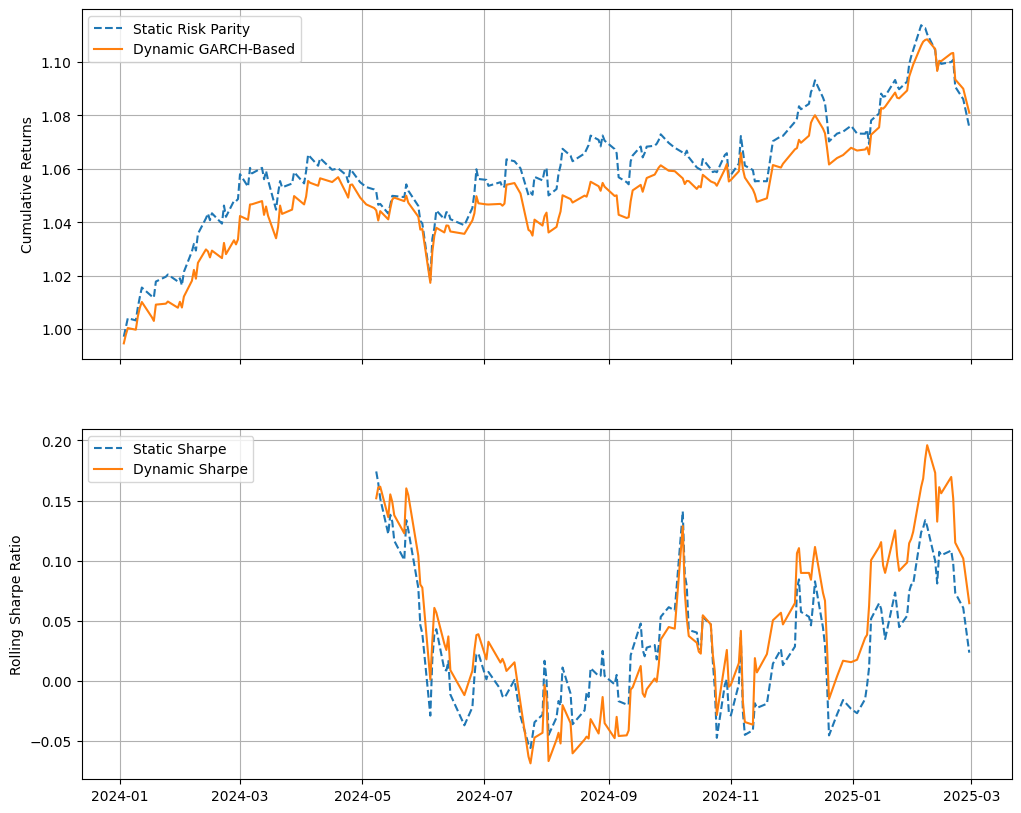

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('prices.csv', index_col=0, parse_dates=True)
test_data = data[data.index >= '2024-01-01']
test_returns = np.log(test_data / test_data.shift(1)).dropna()

vol_forecasts = pd.read_csv('garch_vol_forecasts.csv', index_col=0, parse_dates=True)

# Static Risk Parity Weights
train_data = data[(data.index >= '2015-01-01') & (data.index <= '2023-12-31')]
train_returns = np.log(train_data / train_data.shift(1)).dropna()
inverse_vol = 1 / train_returns.std()
static_weights = inverse_vol / inverse_vol.sum()

# Dynamic Risk Parity Weights
dynamic_weights = 1 / vol_forecasts
dynamic_weights = dynamic_weights.div(dynamic_weights.sum(axis=1), axis=0)

# Portfolio returns
static_portfolio = (test_returns @ static_weights).dropna()
dynamic_portfolio = (test_returns.loc[dynamic_weights.index] * dynamic_weights).sum(axis=1)

# Plot cumulative returns
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

static_cum = (1 + static_portfolio).cumprod()
dynamic_cum = (1 + dynamic_portfolio).cumprod()

axs[0].plot(static_cum, label='Static Risk Parity', linestyle='--')
axs[0].plot(dynamic_cum, label='Dynamic GARCH-Based', linestyle='-')
axs[0].set_ylabel('Cumulative Returns')
axs[0].legend()
axs[0].grid(True)

# Plot rolling Sharpe ratios
rolling_window = 60
risk_free = 0.04 / 252
static_excess = static_portfolio - risk_free
dynamic_excess = dynamic_portfolio - risk_free

static_sharpe = static_excess.rolling(rolling_window).mean() / static_excess.rolling(rolling_window).std()
dynamic_sharpe = dynamic_excess.rolling(rolling_window).mean() / dynamic_excess.rolling(rolling_window).std()

axs[1].plot(static_sharpe, label='Static Sharpe', linestyle='--')
axs[1].plot(dynamic_sharpe, label='Dynamic Sharpe', linestyle='-')
axs[1].set_ylabel('Rolling Sharpe Ratio')
axs[1].legend()
axs[1].grid(True)




In [49]:
plt.tight_layout()
plt.savefig('portfolio_comparison_with_sharpe.png')
plt.show()

<Figure size 640x480 with 0 Axes>